# Spatial Joins
Perform some spatial data wrangling on the airbnb data then load spatial data (boroughs, lsoa) and join the airbnb data to the spatial data.

In [184]:
# load packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [185]:
# load the clean airbnb data into a pandas dataframe
# get the current working directory
cwd = os.getcwd()
path = f"{cwd}/data/inside_airbnb/inside_airbnb_clean.csv"
# create a dataframe of the raw Inside Airbnb data
df = pd.read_csv(path, low_memory=False)

<Axes: >

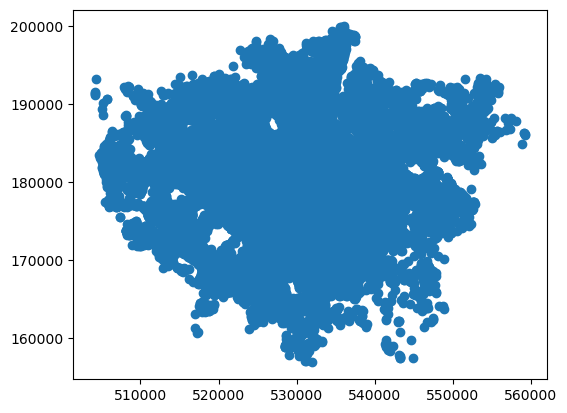

In [186]:
# create a geodataframe of the inside airbnb data, by defaults the crs is epsg 4326
# so also reproject the geodataframe to local crs - epsg: 27700
ab_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326')).to_crs('EPSG:27700')

# quickly plot the data
#ab_gdf.plot()

In [188]:
# Load London Borough and LSOA shapefiles - boroughs downloaded from "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
boro_shp = os.path.join(cwd, "data", "london-boundaries", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")  
lsoa_shp = os.path.join(cwd, "data", "lsoa-boundaries", "merged_lsoa_boundaries_london.shp")  

# read shapefile into geodataframe and reproject crs to 27700
boro_gdf = gpd.read_file(boro_shp).to_crs('EPSG:27700')[['NAME', 'GSS_CODE', 'ONS_INNER', 'geometry']]
lsoa_gdf = gpd.read_file(lsoa_shp).to_crs('EPSG:27700')[['lsoa21cd', 'lsoa21nm', 'lad22cd', 'lad22nm', 'geometry']]

# quickly plot the data
#boro_gdf.plot()
#lsoa_gdf.plot()

In [189]:
# check the crs matches for both gdf
#print(f"ab has a crs of: [{ab_gdf.crs}]")
#print(f"ab has a crs of: [{boro_gdf.crs}]")

# remove any records that fall outside of the london boroughs boundary
ab_gdf_clipped = ab_gdf.clip(boro_gdf)

## Process counts

In [191]:
# counts the airbnb locations within each borough, split by room type
# set new gdf for each room type
entire_ab_gdf = ab_gdf[ab_gdf['room_type'] == "Entire home/apt"]
pr_ab_gdf = ab_gdf[ab_gdf['room_type'] == "Private room"]
other_ab_gdf = ab_gdf[~ab_gdf['room_type'].isin(["Entire home/apt", "Private room"])]

# create point counts per borough
c1 = boro_gdf.join(gpd.sjoin(ab_gdf, boro_gdf).groupby("index_right").size().rename("total_airbnbs"))
c2 = c1.join(gpd.sjoin(entire_ab_gdf, c1).groupby("index_right").size().rename("total_entireha"))
c3 = c2.join(gpd.sjoin(pr_ab_gdf, c2).groupby("index_right").size().rename("total_privateroom"))
boro_count_gdf = c3.join(gpd.sjoin(other_ab_gdf, c3).groupby("index_right").size().rename("total_other"))
# replaces NaN values with zero
## could build funtion to iterate through this
boro_count_gdf['total_entireha'] = boro_count_gdf['total_entireha'].fillna(0).astype('int64')
boro_count_gdf['total_privateroom'] = boro_count_gdf['total_privateroom'].fillna(0).astype('int64')
boro_count_gdf['total_other'] = boro_count_gdf['total_other'].fillna(0).astype('int64')

print(boro_count_gdf)

                      NAME   GSS_CODE ONS_INNER  \
0     Kingston upon Thames  E09000021         F   
1                  Croydon  E09000008         F   
2                  Bromley  E09000006         F   
3                 Hounslow  E09000018         F   
4                   Ealing  E09000009         F   
5                 Havering  E09000016         F   
6               Hillingdon  E09000017         F   
7                   Harrow  E09000015         F   
8                    Brent  E09000005         F   
9                   Barnet  E09000003         F   
10                 Lambeth  E09000022         T   
11               Southwark  E09000028         T   
12                Lewisham  E09000023         T   
13               Greenwich  E09000011         F   
14                  Bexley  E09000004         F   
15                 Enfield  E09000010         F   
16          Waltham Forest  E09000031         F   
17               Redbridge  E09000026         F   
18                  Sutton  E09

In [192]:
# process the same counts as above but at lsoa level
# counts the airbnb locations within each lsoa, split by room type

# create point counts per lsoa
lc1 = lsoa_gdf.join(gpd.sjoin(ab_gdf, lsoa_gdf).groupby("index_right").size().rename("total_airbnbs"))
lc2 = lc1.join(gpd.sjoin(entire_ab_gdf, lc1).groupby("index_right").size().rename("total_entireha"))
lc3 = lc2.join(gpd.sjoin(pr_ab_gdf, lc2).groupby("index_right").size().rename("total_privateroom"))
lsoa_count_gdf = lc3.join(gpd.sjoin(other_ab_gdf, lc3).groupby("index_right").size().rename("total_other"))
# replaces NaN values with zero
lsoa_count_gdf['total_entireha'] = lsoa_count_gdf['total_entireha'].fillna(0).astype('int64')
lsoa_count_gdf['total_privateroom'] = lsoa_count_gdf['total_privateroom'].fillna(0).astype('int64')
lsoa_count_gdf['total_other'] = lsoa_count_gdf['total_other'].fillna(0).astype('int64')

print(lsoa_count_gdf)

       lsoa21cd                   lsoa21nm    lad22cd               lad22nm  \
0     E01000011  Barking and Dagenham 016C  E09000002  Barking and Dagenham   
1     E01000046  Barking and Dagenham 017D  E09000002  Barking and Dagenham   
2     E01000051  Barking and Dagenham 021D  E09000002  Barking and Dagenham   
3     E01000077  Barking and Dagenham 008F  E09000002  Barking and Dagenham   
4     E01000083  Barking and Dagenham 007F  E09000002  Barking and Dagenham   
...         ...                        ...        ...                   ...   
4989  E01004727           Westminster 008D  E09000033           Westminster   
4990  E01035716           Westminster 013G  E09000033           Westminster   
4991  E01004731           Westminster 020A  E09000033           Westminster   
4992  E01004736           Westminster 018C  E09000033           Westminster   
4993  E01035718           Westminster 019G  E09000033           Westminster   

                                               geom

(155000.0, 202000.0)

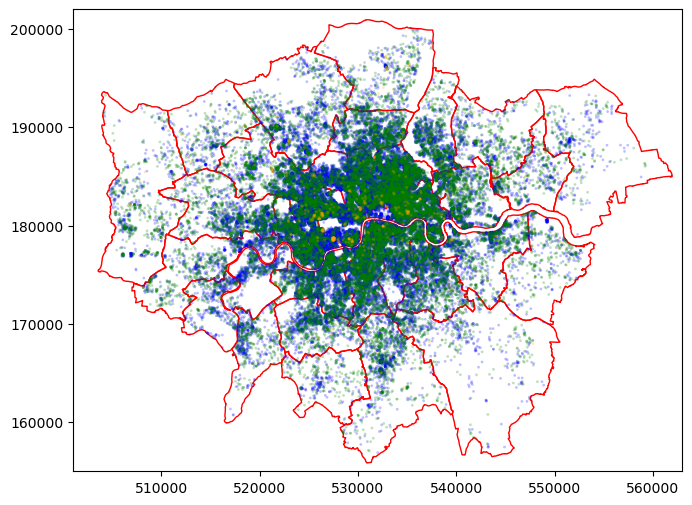

In [193]:
# create a basic map of airbnb locations by borough
# lsoa is not being plotted as at this scale it will overcomplicate the map
fig, ax = plt.subplots(1,1, figsize=(8,6))

# Plot all borough and airbnb data to the same axes
boro_gdf.plot(edgecolor='red', facecolor='none', ax=ax)
entire_ab_gdf.plot(edgecolor='blue', facecolor='none', ax=ax,alpha=0.25, markersize=1.0)
pr_ab_gdf.plot(edgecolor='green', facecolor='none', ax=ax, alpha=0.25, markersize=1.0)
other_ab_gdf.plot(edgecolor='orange', facecolor='none', ax=ax, alpha=0.25, markersize=1.0)

# Set the x and y limits
ax.set_xlim(501000, 563000)
ax.set_ylim(155000, 202000)

# Save the image (dpi is 'dots per inch')
#os.makedirs('img', exist_ok=True)
#plt.savefig(os.path.join('img','borough_map_with_air_bnb_locations.png'), dpi=150)

Due to the relatively low counts of "other" room types we can discount these from our analysis and focus on "Entire Home/apts" and "Private rooms"

In [194]:
# drop the other count column from the gdf
boro_count_gdf = boro_count_gdf.drop(columns=['total_other'])
lsoa_count_gdf = lsoa_count_gdf.drop(columns=['total_other'])

In [195]:
# normalise the counts by area
# create an area columns
boro_count_gdf['area'] = boro_count_gdf.geometry.area
lsoa_count_gdf['area'] = lsoa_count_gdf.geometry.area

# boroughs - Normalize the remaining count columns by dividing by the calculated area
boro_count_gdf['normalised_count_entireha'] = boro_count_gdf['total_entireha'] / boro_count_gdf['area']
boro_count_gdf['normalised_count_privateroom'] = boro_count_gdf['total_privateroom'] / boro_count_gdf['area']

# lsoa - Normalize the remaining count columns by dividing by the calculated area
lsoa_count_gdf['normalised_count_entireha'] = lsoa_count_gdf['total_entireha'] / lsoa_count_gdf['area']
lsoa_count_gdf['normalised_count_privateroom'] = lsoa_count_gdf['total_privateroom'] / lsoa_count_gdf['area']

# Display the updated GeoDataFrame to see the new column
print(boro_count_gdf[['total_entireha', 'total_privateroom', 'area', 'normalised_count_entireha', 'normalised_count_privateroom']].head())
print(lsoa_count_gdf[['total_entireha', 'total_privateroom', 'area', 'normalised_count_entireha', 'normalised_count_privateroom']].head())

   total_entireha  total_privateroom          area  normalised_count_entireha  \
0             396                298  3.726118e+07                   0.000011   
1             786                715  8.649444e+07                   0.000009   
2             421                346  1.501349e+08                   0.000003   
3             734                528  5.592623e+07                   0.000013   
4            1225                940  5.554435e+07                   0.000022   

   normalised_count_privateroom  
0                      0.000008  
1                      0.000008  
2                      0.000002  
3                      0.000009  
4                      0.000017  
   total_entireha  total_privateroom           area  \
0               2                  3   91632.281525   
1               1                  0  155494.033603   
2              12                  3   66632.494899   
3               0                  0  173824.585990   
4               2                 

## Map Borough data

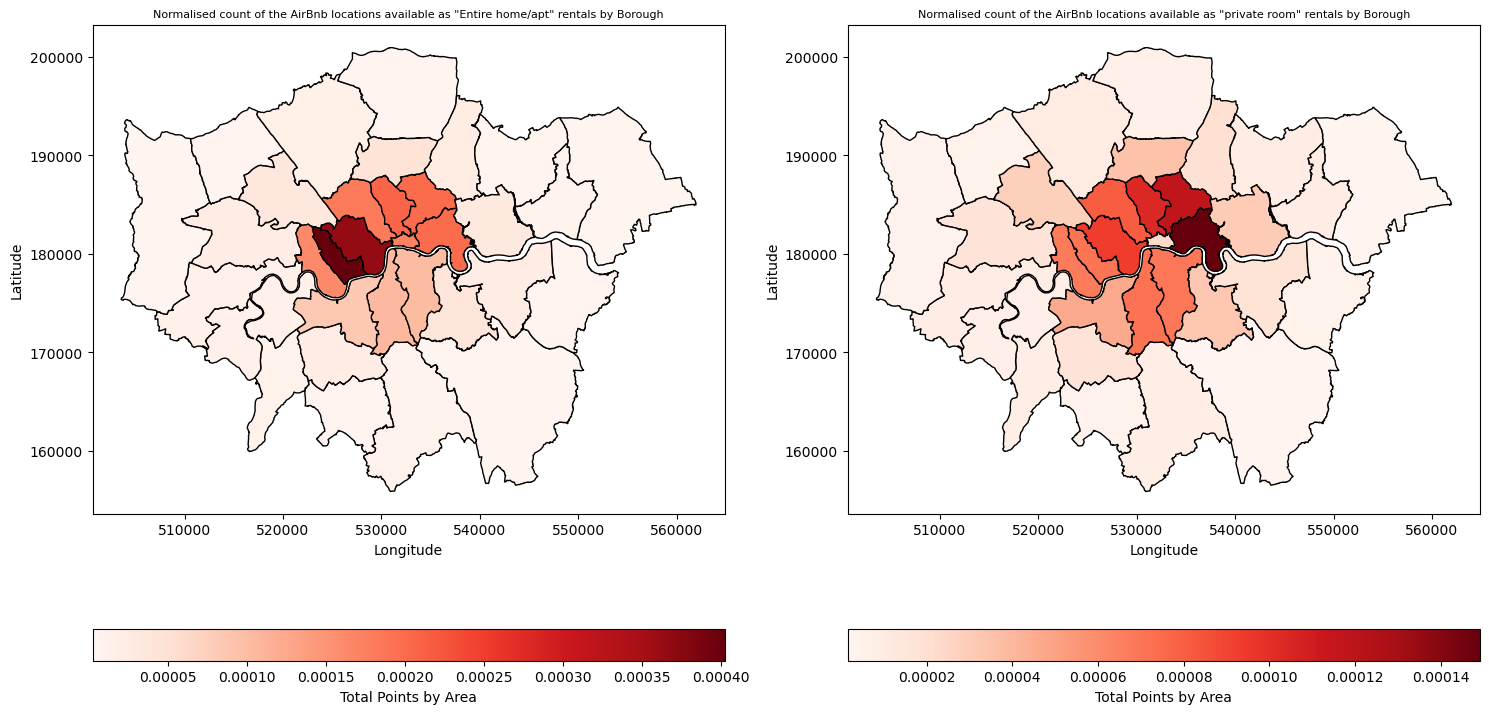

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot using 'total_other' as the value for coloring
boro_count_gdf.plot(column='normalised_count_entireha', ax=axes[0], legend=True,
                    legend_kwds={'label': "Total Points by Area",
                                 'orientation': "horizontal"},
                    cmap='Reds', edgecolor='black')

# Add title and labels
axes[0].set_title("Normalised count of the AirBnb locations available as \"Entire home/apt\" rentals by Borough", fontsize=8)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

boro_count_gdf.plot(column='normalised_count_privateroom', ax=axes[1], legend=True,
                    legend_kwds={'label': "Total Points by Area",
                                 'orientation': "horizontal"},
                    cmap='Reds', edgecolor='black')

# Add title and labels
axes[1].set_title("Normalised count of the AirBnb locations available as \"private room\" rentals by Borough", fontsize=8)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

## Map LSOA data

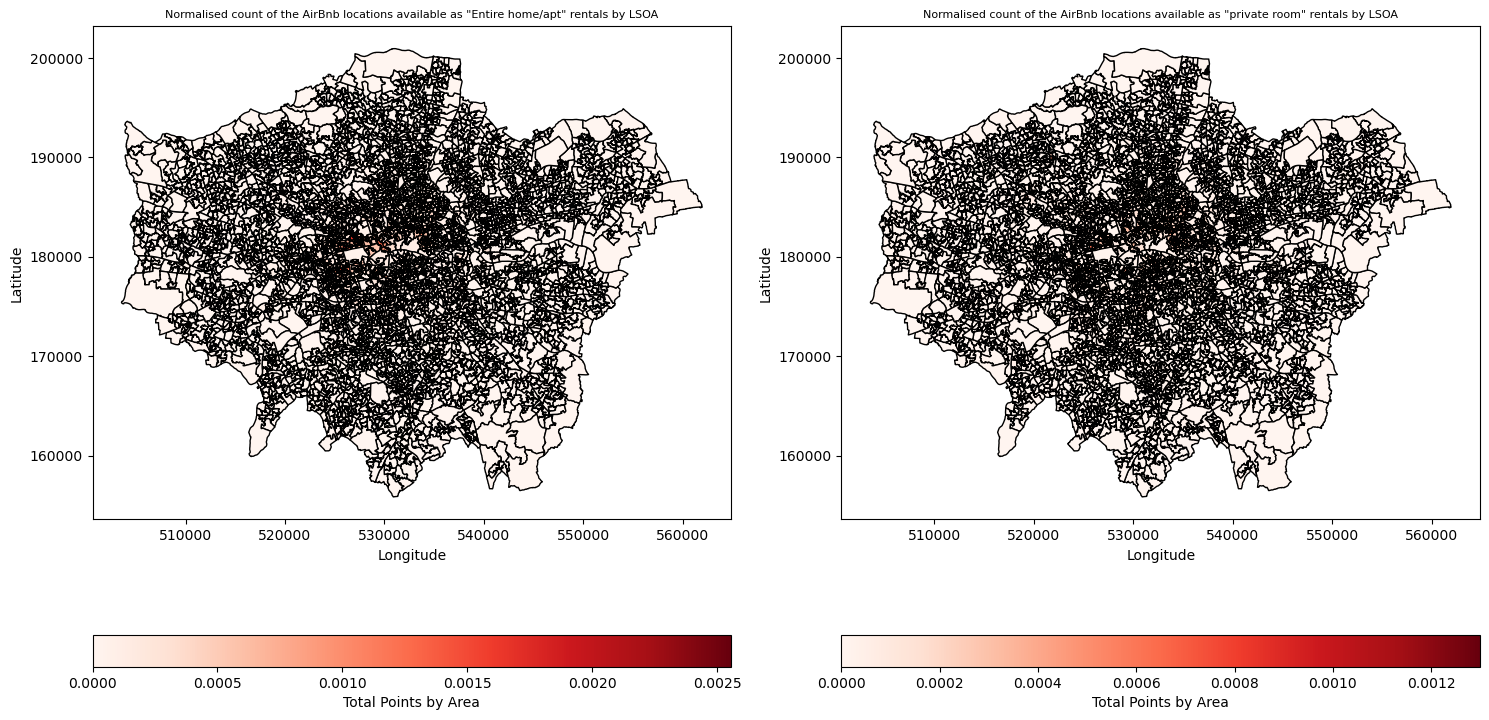

In [181]:
# plot the lsoa normalised counts to a map
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot using 'total_other' as the value for coloring
lsoa_count_gdf.plot(column='normalised_count_entireha', ax=axes[0], legend=True,
                    legend_kwds={'label': "Total Points by Area",
                                 'orientation': "horizontal"},
                    cmap='Reds', edgecolor='black')

# Add title and labels
axes[0].set_title("Normalised count of the AirBnb locations available as \"Entire home/apt\" rentals by LSOA", fontsize=8)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

lsoa_count_gdf.plot(column='normalised_count_privateroom', ax=axes[1], legend=True,
                    legend_kwds={'label': "Total Points by Area",
                                 'orientation': "horizontal"},
                    cmap='Reds', edgecolor='black')

# Add title and labels
axes[1].set_title("Normalised count of the AirBnb locations available as \"private room\" rentals by LSOA", fontsize=8)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

In [203]:
# write the data to be used in further analysis
fn = "borough_counts.csv"
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
boro_count_gdf.to_csv(os.path.join(path,fn), index=False)
#boro_count_gdf.to_file("boro_count.geoparquet")
print("Done.")

Done.


In [204]:
# write the data to be used in further analysis
fn = "lsoa_counts.csv"
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
lsoa_count_gdf.to_csv(os.path.join(path,fn), index=False)
#lsoa_count_gdf.to_file("lsoa_count.geoparquet")
print("Done.")

Done.
